<a href="https://colab.research.google.com/github/NallelyHernandezG/Simulacion-I/blob/main/Algoritmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cantidad óptima a ordenar (q): 54
Nivel óptimo de reorden (R): 106
Costo total mínimo: $1554.00


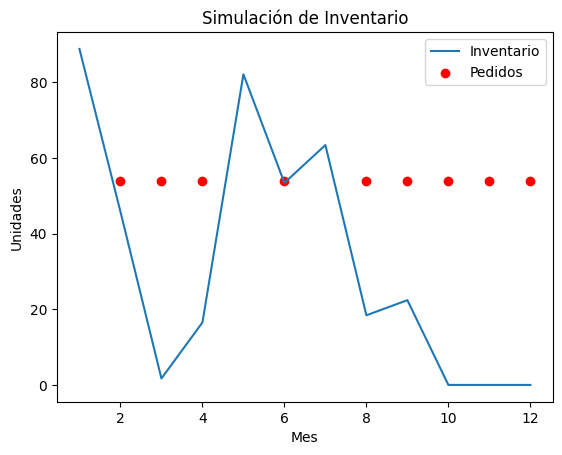

Costo total: $8159.17


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Distribución de la demanda mensual
demanda_mensual = {
    35: 0.010, 36: 0.015, 37: 0.020, 38: 0.020, 39: 0.022,
    40: 0.023, 41: 0.025, 42: 0.027, 43: 0.028, 44: 0.029,
    45: 0.035, 46: 0.045, 47: 0.060, 48: 0.065, 49: 0.070,
    50: 0.080, 51: 0.075, 52: 0.070, 53: 0.065, 54: 0.060,
    55: 0.050, 56: 0.040, 57: 0.030, 58: 0.016, 59: 0.015, 60: 0.005
}

# Distribución del tiempo de entrega
plazos_entrega = {
    1: 0.30, 2: 0.40, 3: 0.30
}

# Factores estacionales
ajustes_estacionales = {
    1: 1.20, 2: 1.00, 3: 0.90, 4: 0.80, 5: 0.80, 6: 0.70,
    7: 0.80, 8: 0.90, 9: 1.00, 10: 1.20, 11: 1.30, 12: 1.40
}

# Costos
costo_pedido = 100
costo_mantener_inventario = 20
costo_desabastecimiento = 50

# Inventario inicial
stock_inicial = 150

# Funciones para generar demanda y tiempo de entrega
def calcular_demanda():
    cantidades = list(demanda_mensual.keys())
    probabilidades = list(demanda_mensual.values())
    return np.random.choice(cantidades, p=probabilidades)

def calcular_tiempo_entrega():
    tiempos = list(plazos_entrega.keys())
    probabilidades = list(plazos_entrega.values())
    return np.random.choice(tiempos, p=probabilidades)

# Función para simular el inventario
def gestionar_inventario(meses=12, q=200, R=100):
    inventario = stock_inicial
    coste_total_pedidos = 0
    coste_total_inventario = 0
    coste_total_faltantes = 0
    registro_inventario = []
    registro_pedidos = []
    registro_faltantes = []

    lista_pedidos = []
    for mes in range(1, meses + 1):
        demanda_mes = calcular_demanda() * ajustes_estacionales[mes]

        # Registrar pedidos si llegan en este mes
        if lista_pedidos:
            for pedido in lista_pedidos.copy():
                if pedido[1] == mes:
                    inventario += pedido[0]
                    lista_pedidos.remove(pedido)

        # Hacer un nuevo pedido si el inventario cae por debajo del punto de reorden
        if inventario < R:
            pedido = q
            tiempo_entrega_mes = calcular_tiempo_entrega()
            lista_pedidos.append((pedido, mes + tiempo_entrega_mes))
            coste_total_pedidos += costo_pedido
            registro_pedidos.append((mes, pedido))

        # Calcular faltantes y actualizar inventario
        if demanda_mes > inventario:
            faltantes = demanda_mes - inventario
            coste_total_faltantes += faltantes * costo_desabastecimiento
            inventario = 0
        else:
            faltantes = 0
            inventario -= demanda_mes

        # Actualizar costos de inventario
        coste_total_inventario += inventario * costo_mantener_inventario / 12
        registro_inventario.append(inventario)
        registro_faltantes.append(faltantes)

    coste_total = coste_total_pedidos + coste_total_inventario + coste_total_faltantes

    return registro_inventario, registro_pedidos, registro_faltantes, coste_total

# Función objetivo para la optimización
def objetivo(params):
    q, R = params
    _, _, _, coste_total = gestionar_inventario(q=int(q), R=int(R))
    return coste_total

# Definir límites
limites = [(50, 250), (50, 200)]

# Ejecutar la optimización usando Differential Evolution
resultado = differential_evolution(objetivo, limites)
mejor_q, mejor_R = resultado.x

print(f'Cantidad óptima a ordenar (q): {int(mejor_q)}')
print(f'Nivel óptimo de reorden (R): {int(mejor_R)}')
print(f'Costo total mínimo: ${resultado.fun:.2f}')

# Ejecutar la simulación con los valores óptimos
registro_inventario, registro_pedidos, registro_faltantes, coste_total = gestionar_inventario(q=int(mejor_q), R=int(mejor_R))

# Visualizar los resultados
meses = range(1, 13)
plt.plot(meses, registro_inventario, label='Inventario')
plt.scatter(*zip(*registro_pedidos), color='red', label='Pedidos')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.title('Simulación de Inventario')
plt.legend()
plt.show()

print(f'Costo total: ${coste_total:.2f}')
